In [1]:
from tinycss2 import tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
from tree_sitter import Parser
import tree_sitter
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import requests
import time

## Preparing Code Completion Dataset

In this section, we prepare a dataset tailored for code completion tasks using a single C++ source file as input. We parse the file using Tree-sitter to extract distinct block-level structures (such as `if` statements, loops, functions, etc.). Each block is categorized by its type, and we count how frequently each type appears.

For the code completion setup, we perform **block sampling**: some of the extracted blocks are partially removed or truncated, and the incomplete versions are used as prompts for a model, which is then evaluated on its ability to complete the missing content.

Finally, we visualize the distribution of the most common block types to better understand the structure of the extracted code.




In [2]:
from tree_sitter_language_pack import get_binding, get_language, get_parser
cpp_parser = get_parser('cpp') 

In [3]:
file_path="src/huffman_code.cpp"
with open(file_path, "r", encoding="utf-8") as f:
    code = f.read()

tree = cpp_parser.parse(bytes(code, "utf8"))
tree

Here we load all node types (i.e., syntactic block types) defined in the C++ grammar file (`grammar.json`). These represent all the constructs that can appear in C++ code, according to the Tree-sitter grammar definition.


In [4]:
import json

with open("grammar.json", "r") as f:
    grammar = json.load(f)

node_types = grammar["rules"].keys()

In [5]:
def extract_blocks(node, source_code):
    blocks = []

    if node.type in node_types:
        blocks.append({
            "type": node.type,
            "code": source_code[node.start_byte:node.end_byte]
        })

    for child in node.children:
        blocks.extend(extract_blocks(child, source_code))

    return blocks


In [6]:
extract_blocks(tree.root_node, code)

[{'type': 'translation_unit',
  'code': '#ifndef __PROGTEST__\n#include <cstring>\n#include <cstdlib>\n#include <cstdio>\n#include <cctype>\n#include <climits>\n#include <cassert>\n#include <cstdint>\n#include <iostream>\n#include <iomanip>\n#include <fstream>\n#include <sstream>\n#include <map>\n#include <vector>\n#include <algorithm>\n#include <set>\n#include <queue>\n#include <memory>\n#include <functional>\n#include <stdexcept>\nusing namespace std;\n#endif /* __PROGTEST__ */\n\nenum GRAPH\n{\n  LEAF = 0, INNODE = 1, DEFAULT = 2\n};\n\n\ntypedef struct tUTF8\n{\n  enum Bytes\n  {\n      UNKNOWN, ONE, TWO, THREE, FOUR\n  };\n\n    unsigned char data[4];\n    Bytes lengthData;\n    tUTF8(void) \n    {\n      for(int i = 0; i < 4; i++)\n        data[i] = \'\\0\'; \n      lengthData = UNKNOWN;\n      }\n    tUTF8(char * inputData, Bytes inputLengthData) : lengthData(inputLengthData) \n    {\n      for(int i = 0; i < inputLengthData; i++)\n        data[i] = inputData[i];\n    }\n    boo

In [7]:
from collections import Counter

blocks = extract_blocks(tree.root_node, code)
block_counts = Counter(block["type"] for block in blocks)

for block_type, count in block_counts.most_common(10):
    print(f"{block_type:10}: {count}")

identifier: 1173
field_expression: 373
argument_list: 277
call_expression: 265
number_literal: 236
expression_statement: 214
binary_expression: 211
primitive_type: 175
compound_statement: 142
parameter_declaration: 132


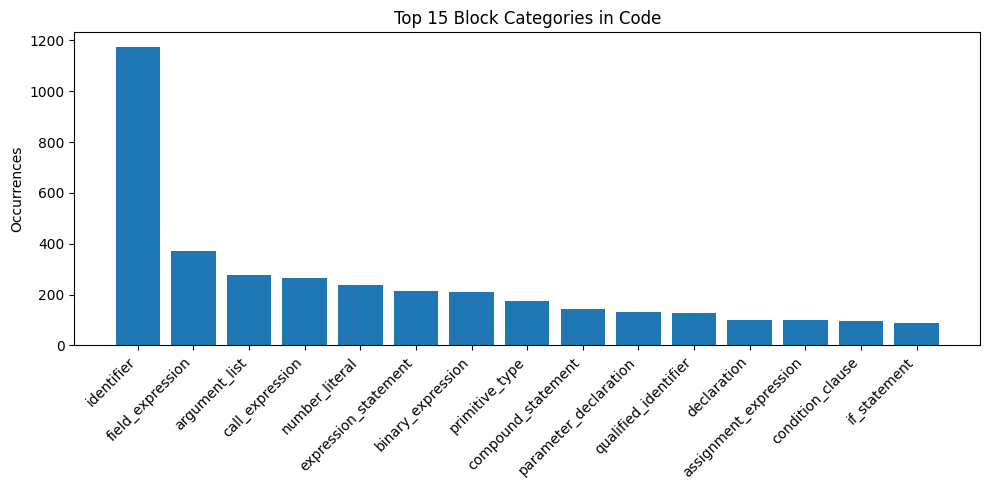

In [8]:
import matplotlib.pyplot as plt


top_n = 15
top_blocks = block_counts.most_common(top_n)
types, counts = zip(*top_blocks)

plt.figure(figsize=(10, 5))
plt.bar(types, counts)
plt.title(f"Top {top_n} Block Categories in Code")
plt.ylabel("Occurrences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Balanced Sampling by Block Type

To ensure fair representation of various code constructs, we apply inverse-frequency weighting to all extracted blocks. This helps us balance the dataset so that both common and rare block types (e.g., `identifier`, `if_statement`, `template_declaration`, etc.) have roughly equal influence when sampling examples for code completion.

In [9]:
from collections import Counter

block_types = [block["type"] for block in blocks]
counter = Counter(block_types)
total = len(blocks)

class_weights = {block_type: total/count for block_type, count in counter.items()}

In [10]:
sample_weights = [class_weights[block["type"]] for block in blocks]
sample_weights[:10]

[5162.0,
 2581.0,
 4.400682011935209,
 271.6842105263158,
 271.6842105263158,
 271.6842105263158,
 271.6842105263158,
 271.6842105263158,
 271.6842105263158,
 271.6842105263158]

In [11]:
for block in blocks:
    block_type = block["type"]
    block["weight"] = class_weights.get(block_type, 1.0)

In [12]:
block

{'type': 'comment', 'code': '/* __PROGTEST__ */', 'weight': 172.06666666666666}

The bar chart below shows the top 30 block categories by total sampling weight — the uniformity confirms that the balancing strategy worked as intended.

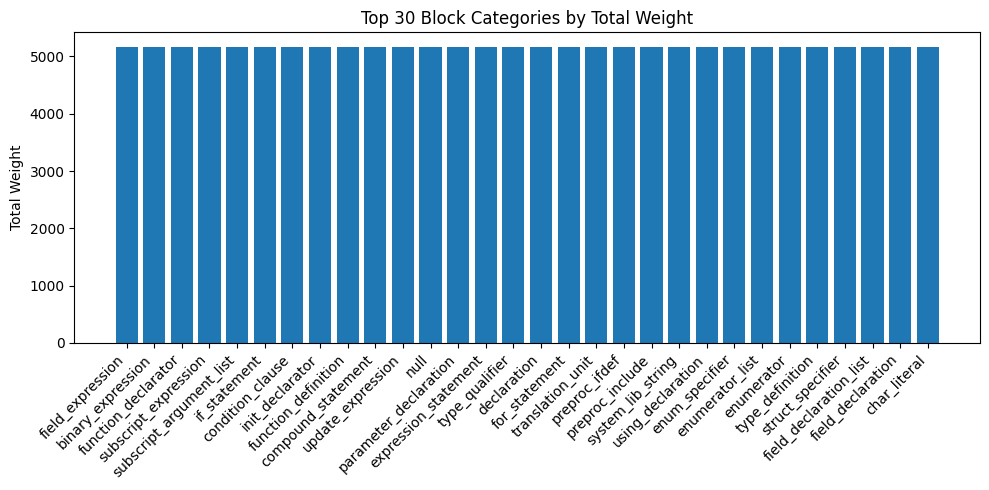

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict


block_weight_totals = defaultdict(float)
for block in blocks:
    block_type = block["type"]
    block_weight_totals[block_type] += block["weight"]

top_n = 30

sorted_weighted = sorted(block_weight_totals.items(), key=lambda x: x[1], reverse=True)
top_blocks = sorted_weighted[:top_n]
types, weights = zip(*top_blocks)

plt.figure(figsize=(10, 5))
plt.bar(types, weights)
plt.title(f"Top {top_n} Block Categories by Total Weight")
plt.ylabel("Total Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


We sample 40 code blocks from the full set, using inverse-frequency weights to ensure balanced representation across block types.

In [14]:
import random

sampled_blocks = random.choices(blocks, weights=[b["weight"] for b in blocks], k=40)

# Metrics

**TSED** measures the **structural similarity** between the generated and reference code by comparing their abstract syntax trees (ASTs). It reflects how many structural operations—such as insertions, deletions, or renames—are needed to transform one tree into the other. This captures one important aspect of code: its overall structural correctness.

**chrF**, on the other hand, captures **surface-level similarity** by comparing character-level n-grams between the generated output and the reference. This makes it sensitive to partially correct completions, such as when variable names, expressions, or formatting are mostly accurate—even if the overall structure differs.



## TSED metric

his cell implements the **TSED** (Tree Structural Edit Distance) metric, which quantifies the syntactic difference between two code blocks by comparing their parse trees.

The TSED metric is defined as:

$$
\text{TSED}(G_1, G_2) = \max \left\{ 1 - \frac{\delta(G_1, G_2)}{\max(\text{Nodes}(G_1), \text{Nodes}(G_2))},\ 0 \right\}
$$

Where:
- $\delta(G_1, G_2)$ is the **APTED** (All Path Tree Edit Distance) between two syntax trees,
- $\text{Nodes}(G)$ is the number of nodes in a given tree $G$,
- The formula ensures the result is in the range $[0, 1]$, where `1` means identical structure and lower values indicate greater differences.

  
Source of this metric is https://arxiv.org/pdf/2404.08817.

The class `APTEDNode` serves as an adapter that converts Tree-sitter nodes into a format compatible with the APTED (Approximate Tree Edit Distance) library. It implements the necessary interface:
- `get_children()` and `get_label()` methods required by APTED.
- The function `convert_ts_to_apted_node()` recursively transforms a Tree-sitter node tree into the APTED-compatible node tree.

This allows us to later compute the structural difference between two pieces of code based on their syntax trees.

In [15]:
from apted import APTED, Config

class APTEDNode:
    def __init__(self, label, children=None):
        self.label = label
        self.children = children or []

    def get_children(self):
        return self.children
    def get_label(self):
        return self.label
        
def convert_ts_to_apted_node(ts_node):
    node = APTEDNode(ts_node.type)
    for child in ts_node.children:
        node.children.append(convert_ts_to_apted_node(child))
    return node



This cell implements the actual TSED (Tree Structural Edit Distance) computation:
- `SimpleConfig` defines uniform costs: 1 for insert/delete/rename, 0 if node labels match.
- `count_nodes()` recursively counts the number of nodes in a Tree-sitter tree.
- `compute_tsed()`:
  - Parses both code snippets into Tree-sitter syntax trees.
  - Converts them into APTED trees using the adapter defined earlier.
  - Computes the tree edit distance using APTED.
  - Normalizes the result by the size of the larger tree to ensure the final TSED score lies in the range [0, 1].

The result reflects how structurally different two code blocks are.


In [16]:
class SimpleConfig(Config):
    def rename(self, node1, node2):
        return 0 if node1.label == node2.label else 1

    def insert(self, node):
        return 1

    def delete(self, node):
        return 1

def count_nodes(ts_node):
    count = 1
    for child in ts_node.children:
        count += count_nodes(child)
    return count

def compute_tsed(tree1_ts_str, tree2_ts_str):
    tree1_ts = cpp_parser.parse(bytes(tree1_ts_str, "utf8"))
    tree2_ts = cpp_parser.parse(bytes(tree2_ts_str, "utf8"))

    t1 = convert_ts_to_apted_node(tree1_ts.root_node)
    t2 = convert_ts_to_apted_node(tree2_ts.root_node)

    ted = APTED(t1, t2, SimpleConfig()).compute_edit_distance()

    max_nodes = max(count_nodes(tree1_ts.root_node), count_nodes(tree2_ts.root_node))
    tsed = max(1 - ted / max_nodes, 0)

    return tsed

Quick sanity check: computing TSED between identical code snippets should return 1.0.

In [17]:
temp = sampled_blocks[0]['code']
compute_tsed(temp,temp)

1.0

## chrf metric



This cell defines a function to compute the **chrF score**, a character n-gram F-score metric commonly used for evaluating text generation quality. It compares the predicted output (`hypothesis`) to the ground truth (`reference`) and returns a score in the range [0, 100], where higher values indicate greater similarity.

We use `sacrebleu.sentence_chrf()` from the `sacrebleu` library to compute the score for a single pair of strings.


In [18]:
import sacrebleu
def compute_chrf(hypothesis, reference):
    return sacrebleu.sentence_chrf(hypothesis, [reference]).score

# Model evaluation

In [19]:
metrics = { "TSED" : compute_tsed, "compute_chrf" : compute_chrf}

This function `extract_prefix_middle_suffix()` splits a full source file into three parts:
- **Prefix**: everything before the sampled block,
- **Middle**: the exact sampled code block (`block["code"]`),
- **Suffix**: everything after the block.

This is used to construct fill-in-the-middle (FIM) prompts

In [20]:
def extract_prefix_middle_suffix(code, block):
    start_index = code.find(block['code'])
    prefix = code[:start_index]
    middle = code[start_index : start_index + len(block['code'])]
    suffix = code[start_index + len(block['code']):]
    return prefix, middle, suffix

prefix, middle, suffix = extract_prefix_middle_suffix(code, sampled_blocks[0])

The `parse_fim_output()` function takes a raw model output string (generated using FIM-style prompting) and extracts:
- `prefix`, `middle`, and `suffix` code parts based on the special markers:
  `<fim_prefix>`, `<fim_suffix>`, `<fim_middle>`.

If any of these markers are missing in the output, the function raises a `ValueError`. This ensures the output format is consistent before evaluation.


In [21]:
def parse_fim_output(generated_text: str):
    if all(tag in generated_text for tag in ("<fim_prefix>", "<fim_suffix>", "<fim_middle>")):
        prefix = generated_text.split("<fim_prefix>")[1].split("<fim_suffix>")[0]
        suffix = generated_text.split("<fim_suffix>")[1].split("<fim_middle>")[0]
        middle = generated_text.split("<fim_middle>")[1]
        return prefix, middle, suffix
    else:
        raise ValueError("Missing one or more FIM markers in model output.")

This function evaluates a fill-in-the-middle (FIM) code completion model on a set of sampled code blocks.

For each block:
- We extract the `prefix`, `middle`, and `suffix` from the full source code.
- A FIM-style prompt is constructed using `<fim_prefix>`, `<fim_suffix>`, and `<fim_middle>` tags.
- The prompt is sent to a hosted Hugging Face model (`starcoder2-3b`) via API.
- The model’s raw output is parsed back into prefix/middle/suffix.
- The predicted middle segment is compared with the ground truth using multiple metrics (e.g., `TSED`, `chrF`), and scores are stored in the `result_score` dictionary.

The function also saves both the predicted and reference outputs to disk for each sample.

**Note**: 
- Evaluation relies on correct formatting of the FIM output.
- Metric functions should be defined in a dictionary named `metrics`, e.g., `{"TSED": compute_tsed, "compute_chrf": compute_chrf}`.

In [24]:
from dotenv import load_dotenv
import os

result_score = { 
    "TSED" : [],
    "compute_chrf" : [],
}

def evaluation_pipeline(sourceCode, sampled_blocks):
    for i in range(len(sampled_blocks)):
        prefix, middle, suffix = extract_prefix_middle_suffix(sourceCode, sampled_blocks[i])
        
        API_URL = "https://api-inference.huggingface.co/models/bigcode/starcoder2-3b"
        load_dotenv()
        API_TOKEN = os.getenv("HF_TOKEN")
        
        headers = {
            "Authorization": f"Bearer {API_TOKEN}"
        }
        fim_prompt = f"<fim_prefix>{prefix}<fim_suffix>{suffix}><fim_middle>"
        
        model_id = "bigcode/starcoder2-3b"
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        payload = {
            "inputs": fim_prompt,
            "parameters": {
                "max_new_tokens": len(tokenizer.encode(middle, add_special_tokens=False)),
                "do_sample": True,
            }
        }
        try:
            response = requests.post(API_URL, headers=headers, json=payload)
            predicted_output = response.json()
            
            if not isinstance(predicted_output, list) or "generated_text" not in predicted_output[0]:
                print(f"Unexpected output format for sample {i}:\n{json.dumps(predicted_output, indent=2)}")
                continue
        except requests.exceptions.RequestException as e:
            print(f"Request error on sample {i}: {e}")
            continue

        except Exception as e:
            print(f"General error on sample {i}: {e}")
            continue                
            
        predicted_generated_text = predicted_output[0]["generated_text"]
        predicted_prefix_fim_filtered, predicted_middle_fim_filtered, predicted_suffix_fim_filtered = parse_fim_output(predicted_generated_text)
        
        for name, func in metrics.items():
            score = func(predicted_middle_fim_filtered, middle)
            result_score[name].append(score)
        with open(f"predictions_ground_truth/ground_truth_sample_{i}.txt", "w") as f:
            f.write(middle )
        with open(f"predictions_ground_truth/predicted_code_sample_{i}.txt", "w") as f:
            f.write( predicted_middle_fim_filtered )
        
evaluation_pipeline(code, sampled_blocks) 

# Review results

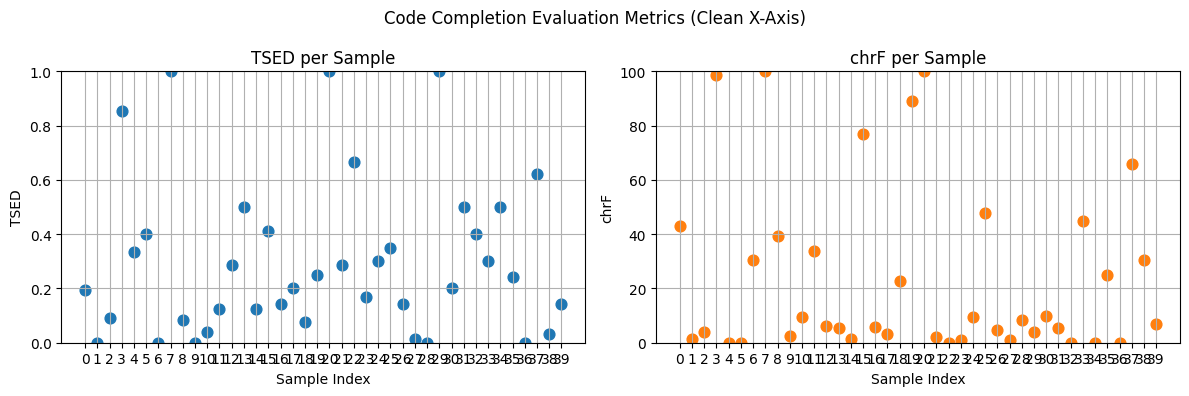

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].scatter(range(len(result_score["TSED"])), result_score["TSED"], color="tab:blue", s=60)
axs[0].set_title("TSED per Sample")
axs[0].set_xlabel("Sample Index")
axs[0].set_ylabel("TSED")
axs[0].set_ylim(0, 1)
axs[0].set_xticks(range(len(result_score["TSED"])))
axs[0].grid(True)

axs[1].scatter(range(len(result_score["compute_chrf"])), result_score["compute_chrf"], color="tab:orange", s=60)
axs[1].set_title("chrF per Sample")
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel("chrF")
axs[1].set_ylim(0, 100)
axs[1].set_xticks(range(len(result_score["compute_chrf"])))
axs[1].grid(True)

plt.suptitle("Code Completion Evaluation Metrics (Clean X-Axis)")
plt.tight_layout()
plt.show()

